## An analysis on arXiv papers where Physics meets Machine Learning

Machine-Learning is definitely the buzziest word in physics these days. You know what I am saying if you've been to APS march meeting 2018. 

In this notebook we have a look at how does this "physics + machine learning" work, by analyzing papers on arXiv.

In [199]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from util import find_prime_authors, name_query
from util import getting_citation_by_title, getting_citation_by_arxiv_id
from pyaxv import arXiv_getter
import pandas as pd
import numpy as np

#### Fetch data from arXiv

Here we use a package *pyaxv*, a package developed by myself, which contains an arXiv scraper "arxiv_getter", to fetch data from arXiv.

In [2]:
arxiv_getter = arXiv_getter()
query = ['neural network','learning','boltzmann machine','recognition']
category = ['quant-ph','cond-mat.dis-nn','cond-mat.mtrl-sci',
            'cond-mat.mes-hall','cond-mat.other','cond-mat.quant-gas',
           'cond-mat.soft','cond-mat.stat-mech','cond-mat.str-el','cond-mat.supr-con',
           'hep-th','hep-ph','hep-lat','math-ph']
df = arxiv_getter.get(query, category,verbose = False)

Start fetching...
Totally 1773 entries


Some paper titled 'what can we learn from' are usually not related to machine learning. Remove them.

In [3]:
df = df.drop(df.index[(df['title'].apply(lambda t: 'we learn' in t.lower()))])
print('Number of entries: {}'.format(df.shape[0]))

Number of entries: 1680


#### Some distributions

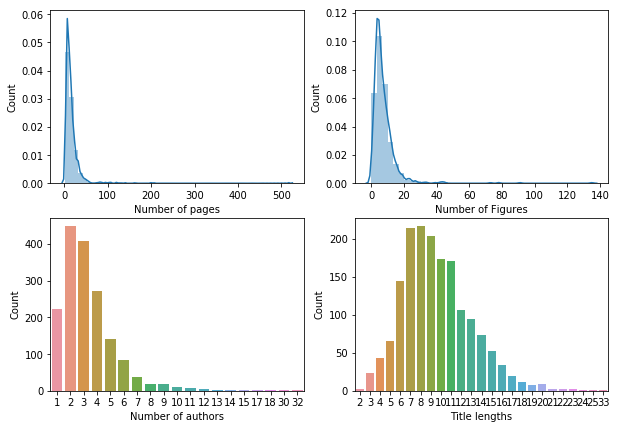

In [4]:
f, axs = plt.subplots(2,2,figsize=(10,7))

plt.subplot(2,2,1)
seaborn.distplot(df.pages[df.pages.notnull()],hist=True,bins=50)
_ = plt.xlabel('Number of pages')
_ = plt.ylabel('Count')

plt.subplot(2,2,2)
seaborn.distplot(df.figures[df.figures.notnull()],hist=True,bins=40)
#_,_,ax = plt.hist(df.figures,bins=40)
_ = plt.xlabel('Number of Figures')
_ = plt.ylabel('Count')

plt.subplot(2,2,3)
seaborn.countplot(x="num_of_authors", data=df)
#_,_,ax = plt.hist(df.num_of_authors,bins=30)
_ = plt.xlabel('Number of authors')
_ = plt.ylabel('Count')

plt.subplot(2,2,4)
seaborn.countplot(x="title_length", data=df)
_ = plt.xlabel('Title lengths')
_ = plt.ylabel('Count')

#### Let's have a look at who contributes most in this area

In [5]:
th=6
names = find_prime_authors(df, threshold=th)
print('Number of prime authors(publication > {}): {} '.format(th, len(names)))
print('total number of papers contributed by these people: ' + str(sum(names)))

Number of prime authors(publication > 6): 42 
total number of papers contributed by these people: 409


#### Visualization

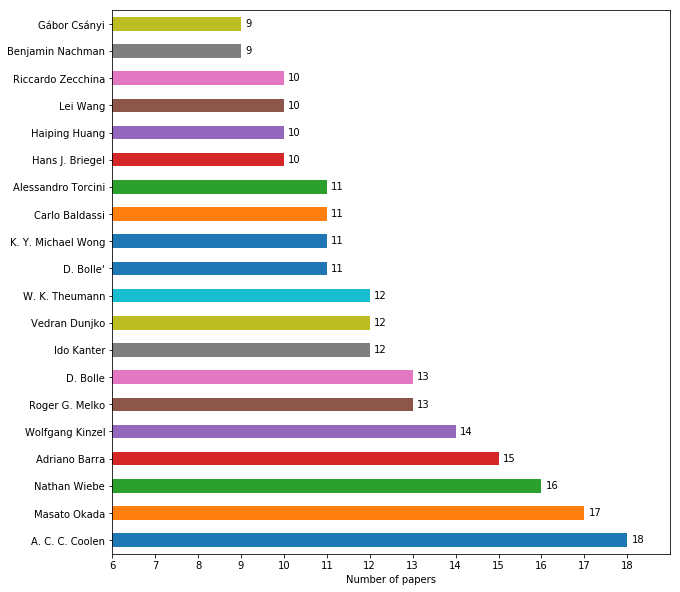

In [6]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)  
plt.xticks(list(range(5,max(names)+1)))
plt.xlim([names[20]-3,max(names)+1])
plt.xlabel('Number of papers')
_ = names[:20].plot.barh()

for i, v in enumerate(names[:20]):
    ax.text(v+0.1 , i-0.1, str(v), color='black', )

Now you know who are leading the hype.

#### Let's have a look at these papers published by Nathan Wiebe, for example

In [9]:
name_query(df,'wiebe')[['arxiv_id', 'title', 'year_of_publishing','month_of_publishing']]

,arxiv_id,title,year_of_publishing,month_of_publishing
765,1807.09753v1,Magnetic-field-learning using a single electro...,2018,7
786,1611.09347v2,Quantum Machine Learning,2016,11
816,1712.07570v1,Experimental Phase Estimation Enhanced By Mach...,2017,12
823,1711.06652v1,Hardening Quantum Machine Learning Against Adv...,2017,11
851,1703.05402v1,Experimental Quantum Hamiltonian Learning,2017,3
872,1512.03145v1,Can small quantum systems learn?,2015,12
883,1412.3489v2,Quantum Deep Learning,2014,12
884,1409.1524v3,Quantum Bootstrapping via Compressed Quantum H...,2014,9
896,1401.2142v2,Quantum Algorithms for Nearest-Neighbor Method...,2014,1
901,1311.5269v2,Quantum Hamiltonian Learning Using Imperfect Q...,2013,11


When did this hype start?

Text(0, 0.5, 'Number of papers')

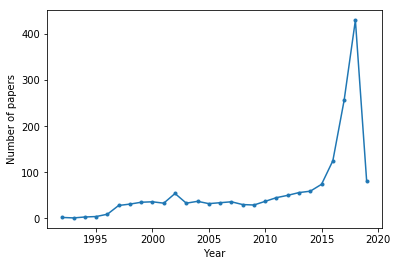

In [8]:
plt.plot(df.year_of_publishing.value_counts().sort_index(),'.-')
plt.xlabel('Year')
plt.ylabel('Number of papers')

The number of papers started exploding pretty much since 2015, when AlphaGo came out.

Let's perform some analysis on the abstracts

In [145]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
#nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn import metrics

In [167]:
abstracts = df.summary.values

porter = PorterStemmer()
def stemSentence(sentence):
    return " ".join(porter.stem(w) for w in word_tokenize(sentence))

abstracts_tokenized = [stemSentence(ab) for ab in abstracts]

n_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(abstracts_tokenized)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(abstracts_tokenized)

### Clustering using K-Means
Here we perform k-means clustering algorithm to split the abstracts into 10 clusters. Here we first reduce the dimensionality of tf-idf features using SVD and normalize them. 

In [168]:
svd = TruncatedSVD(n_components=500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = svd.fit_transform(tfidf)
#X=tfidf
n_clus=10

km = KMeans(n_clusters=n_clus, init='k-means++', max_iter=2000, n_init=1)
km.fit(X)
original_space_centroids = svd.inverse_transform(km.cluster_centers_)

order_centroids = original_space_centroids.argsort()[:, ::-1]

for i in range(n_clus):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % tfidf_feature_names[ind], end='')
        print()

Cluster 0: jet event neutrino higg lhc signal quark background particl network
Cluster 1: network neuron dynam neural activ synapt pattern connect model retriev
Cluster 2: phase transit model learn spin network topolog machin configur neural
Cluster 3: algorithm quantum classic problem queri learn comput log present graph
Cluster 4: quantum learn machin comput qubit classic state thi use algorithm
Cluster 5: decod code error correct neural quantum network nois surfac train
Cluster 6: network data neural use function method model deep train paramet
Cluster 7: learn model gener thi network method use perceptron algorithm time
Cluster 8: materi predict atom structur properti potenti learn energi model machin
Cluster 9: state quantum network bodi neural entangl ground rbm learn use


Here we can see that these abstracts are splitted into different topics. 
Take the first topic for example, it seems that papers in this cluster focus on high-energy particle physics. We shall take one from this group and see if it's really the case.

In [183]:
print('Title: ')
print(df[km.predict(X)==0].title.iloc[0])
print('Abstract: ')
print(abstracts[km.predict(X)==0][0])

Title: 
Using a neural network approach for muon reconstruction and triggering
Abstract: 
  The extremely high rate of events that will be produced in the future Large
Hadron Collider requires the triggering mechanism to take precise decisions in
a few nano-seconds. We present a study which used an artificial neural network
triggering algorithm and compared it to the performance of a dedicated
electronic muon triggering system. Relatively simple architecture was used to
solve a complicated inverse problem. A comparison with a realistic example of
the ATLAS first level trigger simulation was in favour of the neural network. A
similar architecture trained after the simulation of the electronics first
trigger stage showed a further background rejection.



Here we try another method to extract topics. We use Latent Dirichlet Allocation here, which is a generative probabilistic model that particularly useful for abstrac topic discovery.

In [162]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d:\n " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
n_components = 8
n_top_words = 20
print("Fitting LDA models with tf features, "
      "n_features=%d..."
      % (n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_features=1000...

Topics in LDA model:
Topic #0:
 phase transit neuron network coupl oscil dynam electr neural activ thi frequenc model critic synchron spike state respons connect field
Topic #1:
 jet event quark particl lhc bar hadron collis higg search discrimin boson decay qcd tau mass collid gev boost sensit
Topic #2:
 network learn neural dynam model thi gener result function activ use studi statist state neuron number connect theori time random
Topic #3:
 model network thi neural use phase method approach data learn studi pattern physic spin paramet effect process result order differ
Topic #4:
 neutrino sequenc detector al et sourc surfac lin stress amorph thi potenti electron capabl event black distanc sensit gamma puls
Topic #5:
 quantum learn algorithm machin use state thi comput problem network gener classic train method neural data model optim approach measur
Topic #6:
 control learn agent strategi environ reinforc game trap adapt intel

Let's have a look at topic #1, which looks like something related to high-energy particle physics

In [185]:
print('Title:')
print(df[lda.transform(tf).argmax(axis=1)==1].title.iloc[20])
print('abstract:')
print(abstracts[lda.transform(tf).argmax(axis=1)==1][20])

Title:
Deep learning in color: towards automated quark/gluon jet discrimination
abstract:
  Artificial intelligence offers the potential to automate challenging
data-processing tasks in collider physics. To establish its prospects, we
explore to what extent deep learning with convolutional neural networks can
discriminate quark and gluon jets better than observables designed by
physicists. Our approach builds upon the paradigm that a jet can be treated as
an image, with intensity given by the local calorimeter deposits. We supplement
this construction by adding color to the images, with red, green and blue
intensities given by the transverse momentum in charged particles, transverse
momentum in neutral particles, and pixel-level charged particle counts.
Overall, the deep networks match or outperform traditional jet variables. We
also find that, while various simulations produce different quark and gluon
jets, the neural networks are surprisingly insensitive to these differences,
simila

It works exactly as expected.

Check the distribution of each topic

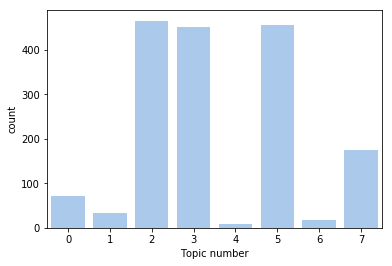

In [204]:
topics = lda.transform(tf).argmax(axis=1)
sns.set_color_codes("pastel")
sns.countplot(pd.Series(topics),color='b')
_ = plt.xlabel('Topic number')

Topics that take part in majority of the dataset are 2,3, and 5.

Based on the top words, we suppose these topics are related to
* 2: something related to neural science
* 3: something related to quantum condensed matter physics, particularly quantum Hall effect
* 5: quantum algorithms related to machine learning

Let's first have a look at topic 2

In [206]:
print('Title:')
print(df[lda.transform(tf).argmax(axis=1)==2].title.iloc[20])
print('abstract:')
print(abstracts[lda.transform(tf).argmax(axis=1)==2][20])

Title:
Single neuron properties shape chaotic dynamics in random neural
  networks
abstract:
  Cortical neurons exhibit rich dynamics, shaped by the presence of
history-dependent biophysical mechanisms such as adaptation over different time
scales. On the other hand, cortical circuits are highly recurrent which can
result in chaotic network dynamics even if network nodes have simple dynamics.
We analyze how the dynamics of nodes (such as single neurons) and recurrent
connections interact to shape the effective dynamics in large randomly
connected networks. A novel dynamical mean-field theory for networks of
multi-dimensional rate units shows that, despite the nonlinear interactions
between units, the recurrent network dynamics inherit, in the chaotic phase,
the qualitative features of the linear response properties of the single units.
For the case of two-dimensional rate units with strong adaptation, we find that
the network exhibits a state of "resonant chaos", whose resonance freque

So this is something related to neuro science. Now check topic 3:

In [207]:
print('Title:')
print(df[lda.transform(tf).argmax(axis=1)==3].title.iloc[20])
print('abstract:')
print(abstracts[lda.transform(tf).argmax(axis=1)==3][20])

Title:
Probing topological properties of 3D lattice dimer model with neural
  networks
abstract:
  Here, we consider a simple problem, demonstrating that neural networks can be
successfully used to give new insights in statistical physics. Specifically, we
consider 3D lattice dimer model, which consists of sites forming a lattice and
bonds connecting the neighboring sites, in such a way that every bond can be
either empty of filled with a dimer, and the total number of dimers ending at
one site is fixed to be one. Dimer configurations can be viewed as equivalent
if they are connected through a series of local flips, i.e. simultaneous
'rotation' of a pair of parallel neighboring dimers. It turns out that the
whole set of dimer configurations on a given 3D lattice can be split into
distinct topological classes, such that dimer configurations belonging to
different classes are not equivalent. In this paper we identify these classes
by using neural networks. More specifically, we train the

Exactly as expected. How about topic #5?

In [208]:
print('Title:')
print(df[lda.transform(tf).argmax(axis=1)==5].title.iloc[20])
print('abstract:')
print(abstracts[lda.transform(tf).argmax(axis=1)==5][20])

Title:
Neural Belief-Propagation Decoders for Quantum Error-Correcting Codes
abstract:
  Belief-propagation (BP) decoders play a vital role in modern coding theory,
but they are not suitable to decode quantum error-correcting codes because of a
unique quantum feature called error degeneracy. Inspired by an exact mapping
between BP and deep neural networks, we train neural BP decoders for quantum
low-density parity-check (LDPC) codes with a loss function tailored to error
degeneracy. Training substantially improves the performance of BP decoders for
all families of codes we tested and may solve the degeneracy problem which
plagues the decoding of quantum LDPC codes.



In [209]:
df.to_csv('arxiv_phys_ML.csv')